# A Comparison of the Monte Carlo Method: Quantum vs. Classical Computers
This notebook demonstrates the application of the Monte Carlo method for (biased) coin toss games, using both quantum and classical computers. However, due to the current lack of perfect quantum machines, we utilize the Qiskit Aer simulator to simulate the behavior of a quantum computer.

This notebook compares the performance of a method using the Quantum Amplitude Estimation (QAE for short) algorithm, which is often described as a quantum version of the Monte Carlo method, and the usual Monte Carlo method, highlighting the potential advantages offered by quantum computing for tackling Monte Carlo simulations.

As for the details of QAE, see [Brassard et al.](https://arxiv.org/abs/quant-ph/0005055), [Montanaro](https://arxiv.org/abs/1504.06987), and [Stamatopoulos et al.](https://arxiv.org/abs/1905.02666)

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import WeightedAdder, IntegerComparator
from qiskit import Aer, transpile
from qiskit.circuit.library import HGate, RYGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution

from qiskit.circuit.library import GroverOperator, PhaseEstimation
from qiskit.algorithms import EstimationProblem
from qiskit.algorithms import AmplitudeEstimation
from qiskit.algorithms import IterativeAmplitudeEstimation
# from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation
# from qiskit.algorithms import FasterAmplitudeEstimation
from qiskit.primitives import Sampler
from qiskit.algorithms import AmplitudeEstimation

import numpy as np
from scipy.special import comb
from scipy.stats import bernoulli

In [2]:
backend = AerSimulator()

## Implementing a Coin Toss Game on a Quantum Circuit
We consider an $n$-coin toss game where the probability of getting a head is $p~(0\leq p\leq 1)$ for each coin.
We aim to calculate the expectation of the number of heads using quantum computing.
We now set $n=7$ and $p=1/3$.
Then, the expectation is $7/3=2.333...$

Here, we use the [`WeightedAdder`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.WeightedAdder.html) circuit from Qiskit to store the results of the sum of the number of heads.
We write this circuit as "$\sum_jq_j$".
`n_state_qubits` below represents the number of coins.

Number of ancillas: 3
Number of qubits to store sum: 3
Number of all qubits: 13


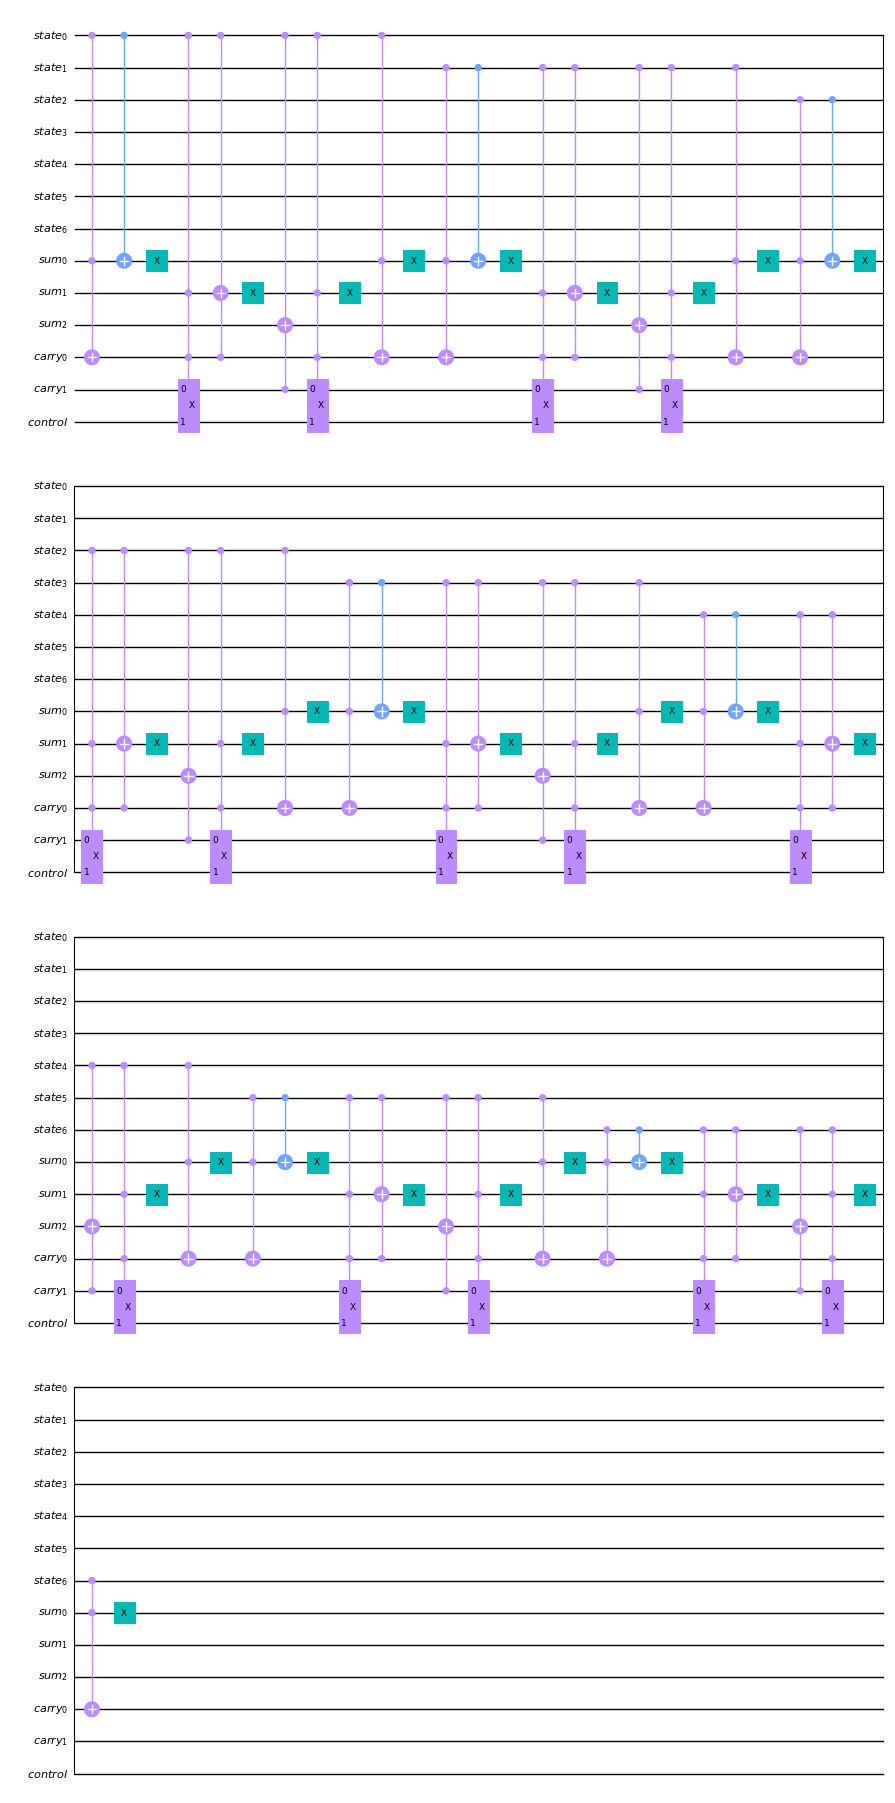

In [3]:
n_state_qubits = 7

qc_wadder = WeightedAdder(n_state_qubits, name='     $\sum_jq_j$     ')
n_ancillas = qc_wadder.num_ancillas
n_sum_qubits = qc_wadder.num_sum_qubits
n_qubits = qc_wadder.num_qubits
print(f'Number of ancillas: {n_ancillas}')
print(f'Number of qubits to store sum: {n_sum_qubits}')
print(f'Number of all qubits: {n_qubits}')
qc_wadder.decompose(reps=1).draw('mpl', scale=0.5)

Each qubit $q_j$ below represents a coin, where the tail is $|0\rangle$ and the head is $|1\rangle$, and the sum $\sum_jq_j$ is stored on the qubits $|\textrm{sum}_0\rangle|\textrm{sum}_1\rangle\textrm{sum}_2\rangle$ in 3-digit binary.

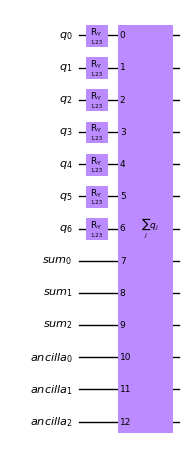

In [4]:
p = 1 / 3
theta = 2 * np.arcsin(np.sqrt(p))

qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qc = QuantumCircuit(qr_state, qr_sum, qr_a)
for i in range(n_state_qubits):
    qc.ry(theta, i)

qc.append(qc_wadder.to_gate(), qargs=range(n_qubits))

U = qc.to_gate()
U.name = '    $U$    '
qc.draw('mpl', scale=0.5)

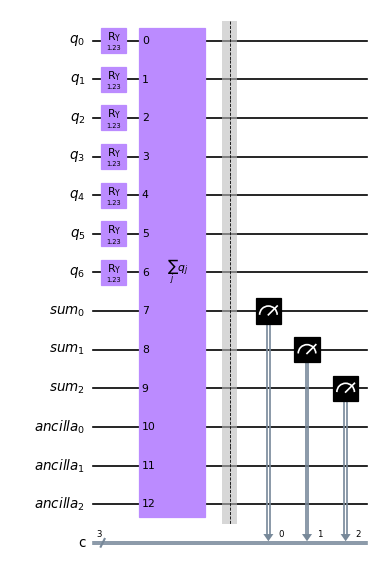

In [5]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qc = QuantumCircuit(qr_state, qr_sum, qr_a)
qc.append(U, qargs=range(n_qubits))

qc.barrier()
cr = ClassicalRegister(n_sum_qubits, 'c')
qc.add_register(cr)
qc.measure(range(n_state_qubits, n_state_qubits + n_sum_qubits), cr)
qc.decompose().draw('mpl', scale=0.6)

Below is a histogram representing the observed distribution of the number of heads.
We can get it by measuring the state on the circuit.

{'100': 1293, '101': 397, '011': 2687, '010': 2973, '001': 2003, '110': 66, '000': 575, '111': 6}
CPU times: total: 15.6 ms
Wall time: 57.8 ms


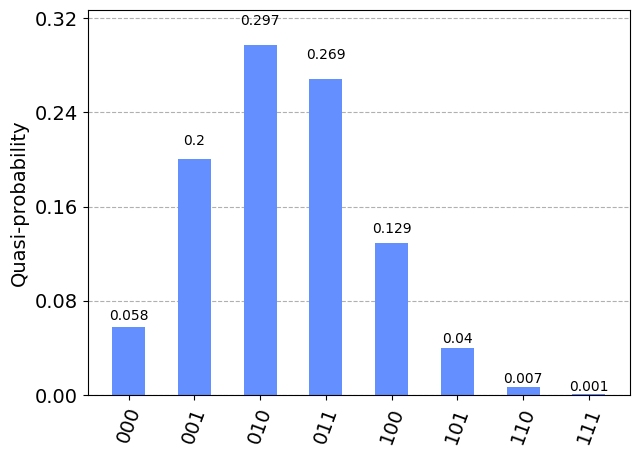

In [6]:
%%time
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_distribution(counts)

## Upper Probability Estimates
Let us calculate the upper probability of the distribution of the number of heads using the circuit implemented earlier.
Here we calculate the probability that the number of heads is greater than or equal to 6.
We use the [`IntegerComparator`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.IntegerComparator.html) circuit from Qiskit, which stores True $|1\rangle$ or False $|0\rangle$ according to the result of the comparison.

Number of ancillas: 2


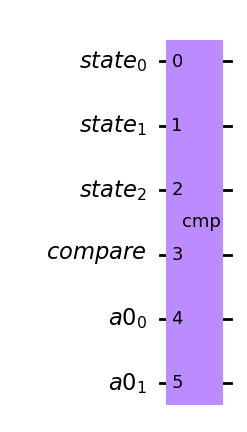

In [7]:
value = 6
qc = IntegerComparator(n_sum_qubits, value=value)
n_anccmp = qc.num_ancillas
print(f'Number of ancillas: {n_anccmp}')
U_cmp = qc.to_gate()
qc.draw('mpl')

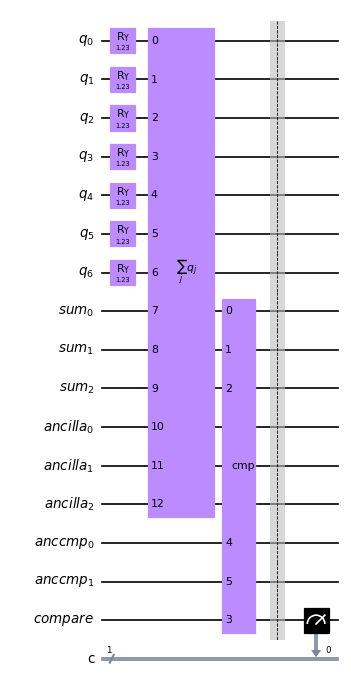

In [8]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qr_acmp = QuantumRegister(n_anccmp, 'anccmp')
qr_cmp = QuantumRegister(1, 'compare')
qc = QuantumCircuit(qr_state, qr_sum, qr_a, qr_acmp, qr_cmp)

qc.append(U, qargs=range(n_qubits))
qargs = list(range(n_state_qubits, n_state_qubits + n_sum_qubits)) \
        + [n_state_qubits + n_sum_qubits + n_ancillas + n_anccmp] \
        + list(range(n_state_qubits + n_sum_qubits + n_ancillas, 
            n_state_qubits + n_sum_qubits + n_ancillas + n_anccmp))
qc.append(U_cmp, qargs=qargs)

U_upper = qc.to_gate()
U_upper.name = '   $U_{upper\,pr}$   '

qc.barrier()
cr = ClassicalRegister(1, 'c')
qc.add_register(cr)
qc.measure(qc.num_qubits - 1, cr)
qc.decompose().draw('mpl', scale=0.6)

Measuring the qubit "compare" gives us an estimate of this probability.

{'0': 99338, '1': 662}
CPU times: total: 1.92 s
Wall time: 205 ms


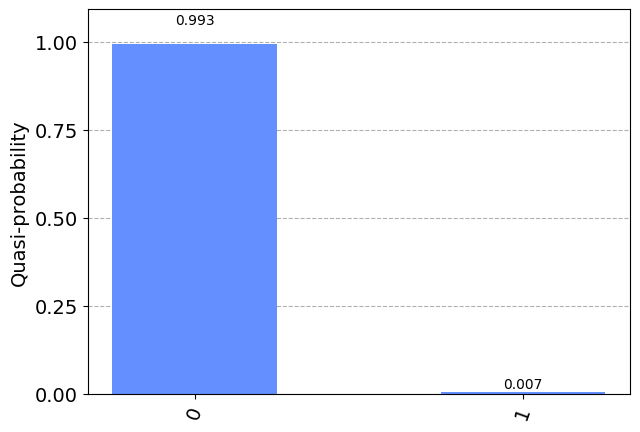

In [9]:
%%time
n_shots = 100000
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=n_shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_distribution(counts)

We perform the (classical) Monte Carlo method to this problem and get an estimate.

In [10]:
%%time
n_coins = n_state_qubits
n_samples = 100000
count = 0
for i in range(n_samples):
    if np.sum(bernoulli.rvs(p, size=n_coins)) >= value:
        count += 1

print(f'Monte Carlo Estimate: {count / n_samples}')

Monte Carlo Estimate: 0.00703
CPU times: total: 406 ms
Wall time: 1.86 s


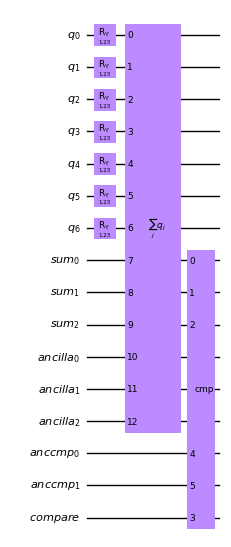

In [11]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qr_acmp = QuantumRegister(n_anccmp, 'anccmp')
qr_cmp = QuantumRegister(1, 'compare')
qc = QuantumCircuit(qr_state, qr_sum, qr_a, qr_acmp, qr_cmp)

qc.append(U_upper, qargs=range(qc.num_qubits))

qc.decompose(reps=2).draw('mpl', scale=0.5)

Construct a Grover operator using [`GroverOperator`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.GroverOperator.html) class from Qiskit.

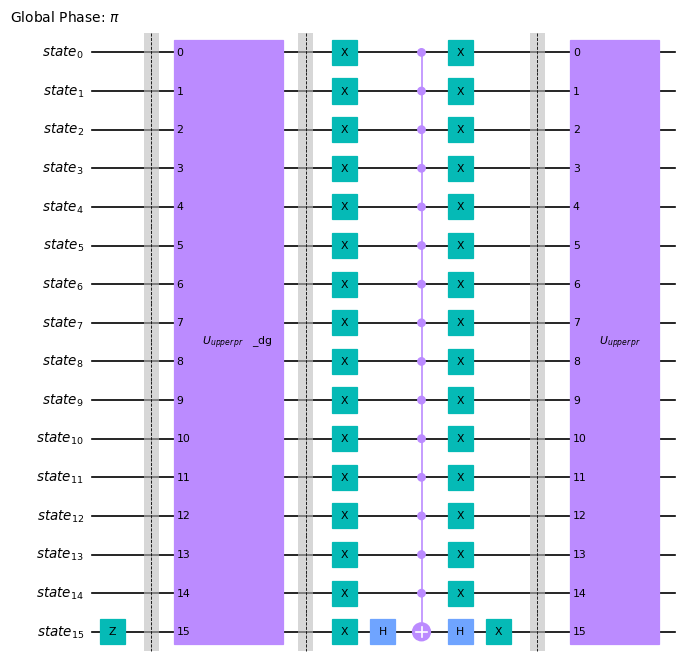

In [12]:
oracle = QuantumCircuit(qc.num_qubits)
oracle.z(qc.num_qubits - 1)
Q = GroverOperator(oracle, state_preparation=qc, insert_barriers=True)
Q.decompose().draw('mpl', scale=0.6)

Here we use the _iterative QAE (IQAE)_ method instead of the original QAE because there are already many qubits in the circuit, which makes it difficult to run on a simulator due to the additional qubit requirement.
The original QAE requires a number of qubits proportional to the precision of the estimates based on QPE (Quantum Phase Estimation), whereas IQAE can work without QPE, therefore, additional qubits are not required.
Instead, the Grover operator $Q$ needs to be applied repeatedly.
However, [`IterativeAmplitudeEstimation`](https://qiskit.org/documentation/stubs/qiskit.algorithms.IterativeAmplitudeEstimation.html) class makes it unnecessary to be concerned about the details of the algorithm.

For detail of IQAE, see [Grinko et al.](https://arxiv.org/abs/1912.05559)

In [13]:
problem = EstimationProblem(
    state_preparation=qc,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[qc.num_qubits - 1],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

sampler = Sampler()

In [14]:
%%time
iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

CPU times: total: 78.1 ms
Wall time: 406 ms


In [15]:
print(f'Estimate (IQAE): {iae_result.estimation}')
print(f'Estimate (Monte Calro): {count / n_samples} ({n_samples} samples)')
theoretical_probs = np.array([comb(n_state_qubits, j) * p ** j * (1 - p) ** (n_state_qubits - j) 
                     for j in range(n_state_qubits + 1)])
print(f'Theoretical: {np.sum(theoretical_probs[value:])}')

Estimate (IQAE): 0.0068587105624143
Estimate (Monte Calro): 0.00703 (100000 samples)
Theoretical: 0.006858710562414264


As can be seen from the results above, the estimate of the IQAE is quite close to the theoretical value, in fact almost identical to it, whereas the Monte Carlo method would require more samples to bring the estimates closer to it.

## Expectation Value Estimates
We need to apply controlled rotation gates to obtain the expectation. The angles of rotation are obtained after adjusting the integrands to be less than 1, with the reciprocal of the adjustment coefficients as the `denominator` below.

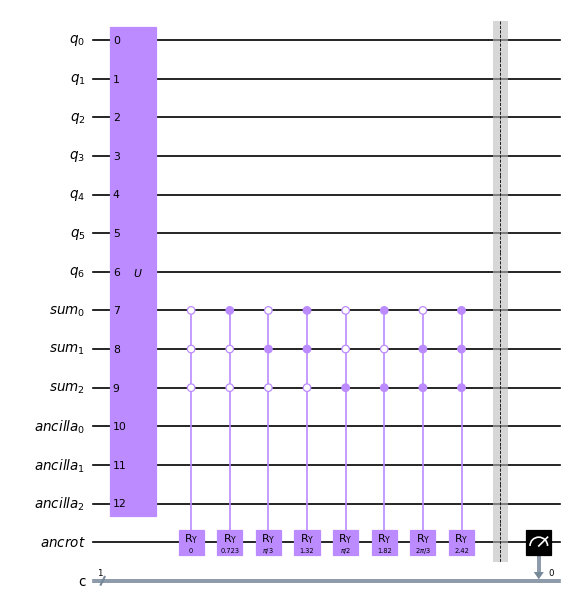

In [16]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qr_arot = QuantumRegister(1, 'ancrot')
qc = QuantumCircuit(qr_state, qr_sum, qr_a, qr_arot)
qc.append(U, qargs=range(n_qubits))

denominator = 2 ** n_sum_qubits
qargs_rot = list(range(n_state_qubits, n_state_qubits + n_sum_qubits)) + [qc.num_qubits - 1]
for i in range(2 ** n_sum_qubits):
    _theta = 2 * np.arcsin(np.sqrt(i / denominator))
    _RGate = RYGate(_theta).control(n_sum_qubits, ctrl_state=i)
    qc.append(_RGate, qargs=qargs_rot)

U_mc = qc.to_gate()
U_mc.name = 'MC gate'

qc.barrier()
cr = ClassicalRegister(1, 'c')
qc.add_register(cr)
qc.measure(qc.num_qubits - 1, cr)
qc.decompose(reps=0).draw('mpl', scale=0.6)

{'1': 29277, '0': 70723}
CPU times: total: 141 ms
Wall time: 401 ms


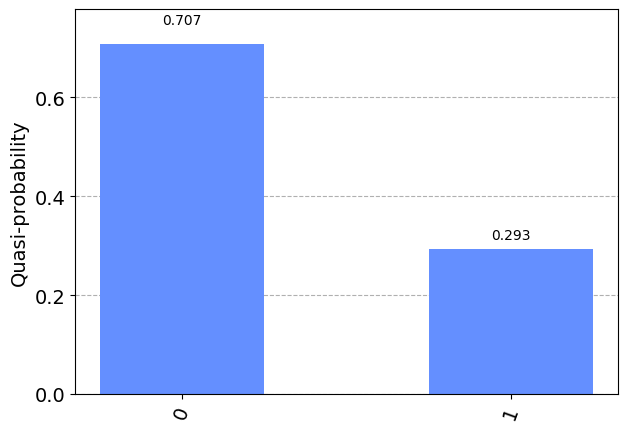

In [17]:
%%time
n_shots = 100000
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=n_shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_distribution(counts)

A result of the classical Monte Carlo method is below.

In [18]:
%%time
n_coins = n_state_qubits
n_samples = 100000
count = 0
for i in range(n_samples):
    count += np.sum(bernoulli.rvs(p, size=n_coins))

sample_mean = count / n_samples
print(f'Monte Carlo Estimate: {sample_mean}')

Monte Carlo Estimate: 2.33993
CPU times: total: 2.69 s
Wall time: 5 s


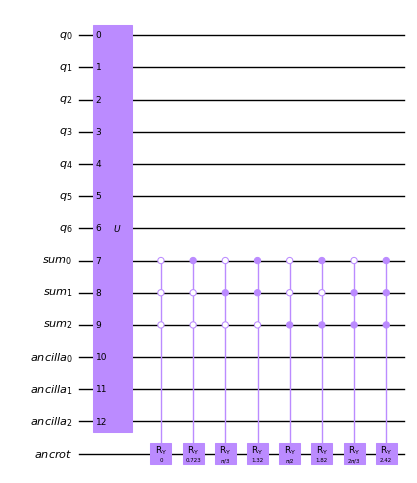

In [19]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qr_arot = QuantumRegister(1, 'ancrot')
qc = QuantumCircuit(qr_state, qr_sum, qr_a, qr_arot)
qc.append(U_mc, qargs=range(qc.num_qubits))

qc.decompose(reps=1).draw('mpl', scale=0.5)

As in "Upper Probability Estimates", we perform the IQAE after constructing a Grover operator $Q$.

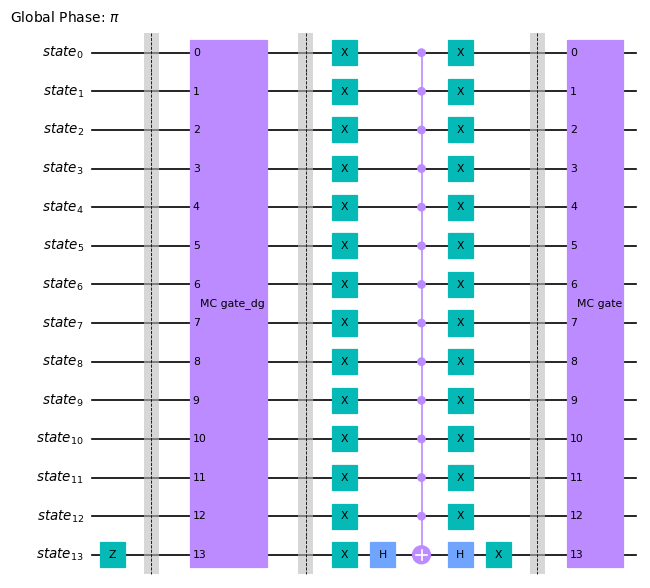

In [20]:
oracle = QuantumCircuit(qc.num_qubits)
oracle.z(qc.num_qubits - 1)
Q = GroverOperator(oracle, state_preparation=qc, insert_barriers=True)
Q.decompose().draw('mpl', scale=0.6)

In [21]:
problem = EstimationProblem(
    state_preparation=qc,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[qc.num_qubits - 1],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

sampler = Sampler()

In [22]:
%%time
iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

CPU times: total: 219 ms
Wall time: 549 ms


In [23]:
print(f'Estimate (IQAE): {denominator * iae_result.estimation}')
print(f'Estimate (Monte Carlo): {sample_mean} ({n_samples} samples)')
print(f'Theoretical: {np.array(range(n_state_qubits + 1)) @ theoretical_probs}')

Estimate (IQAE): 2.333333333333336
Estimate (Monte Carlo): 2.33993 (100000 samples)
Theoretical: 2.3333333333333344


We see that the IQAE gives a good estimate.